In [25]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Constants

In [51]:
BONE_CONNECTIONS = [

    # Face - Neck - Shoulder
    [2,0,3],
    [2,0,4],

    # Elbow - Shoulder - Shoulder
    [7,3,4],
    [8,4,3],

    #elbow - shoulder - hip
    [7,3,5],
    [8,4,6],

    #wrist - elbow - shoulder
    [11,7,3],
    [12,8,4],

    #shoulder - hip - knee
    [3,5,9],
    [4,6,10],

    #hip - knee - ankle
    [5,9,13],
    [6,10,14],
]

# Now the processing

In [20]:
DRIVE_DIR = "H:/JHMDB"

JOINT_POSITION_FOLDER = f"{DRIVE_DIR}/joint_positions/joint_positions"
CLASSES = os.listdir(JOINT_POSITION_FOLDER)
#remove some random folders
for c in CLASSES: 
    if c[0] == ".": CLASSES.remove(c)

print(CLASSES)

['clap', 'swing_baseball', 'pour', 'run', 'wave', 'shoot_gun', 'shoot_ball', 'throw', 'golf', 'brush_hair', 'shoot_bow', 'stand', 'sit', 'climb_stairs', 'jump', 'pullup', 'pick', 'kick_ball', 'walk', 'push', 'catch']


(2, 15, 40)
[2, 0, 3]


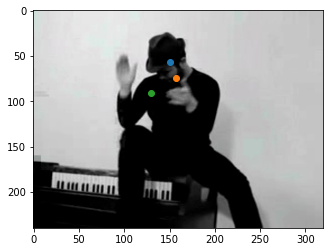

[2, 0, 4]


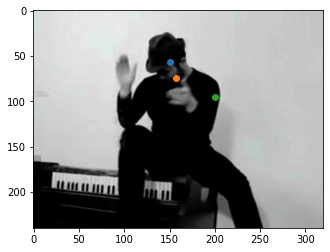

[7, 3, 4]


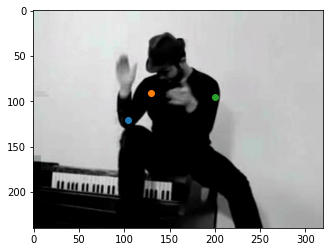

[8, 4, 3]


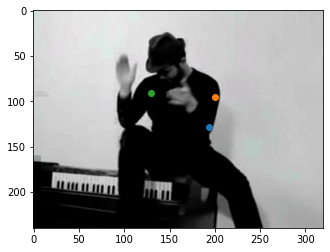

[7, 3, 5]


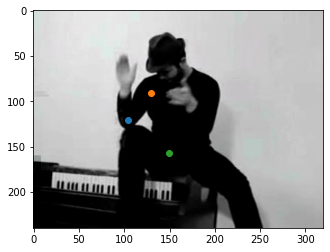

[8, 4, 6]


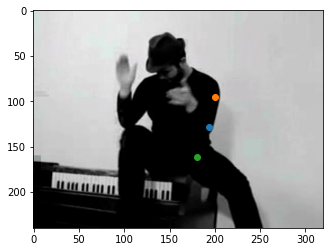

[11, 7, 3]


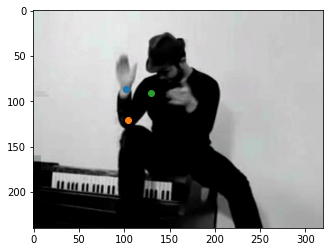

[12, 8, 4]


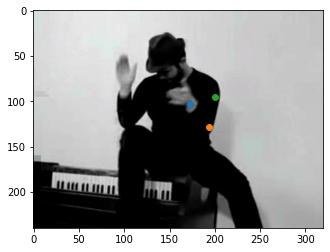

[3, 5, 9]


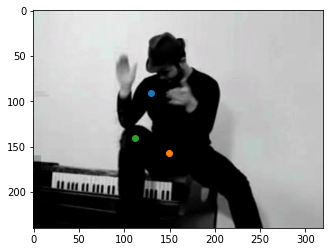

[4, 6, 10]


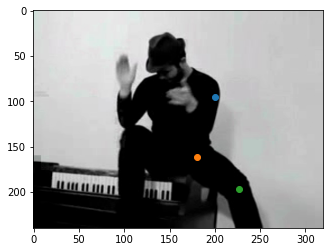

[5, 9, 13]


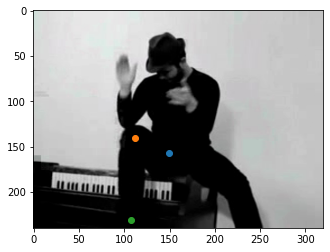

[6, 10, 14]


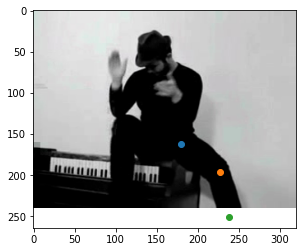

In [58]:
for c in CLASSES:

    for i in os.listdir(f"{JOINT_POSITION_FOLDER}/{c}"):
        if i[0] == ".": continue

        joint_positions = scipy.io.loadmat(f"{JOINT_POSITION_FOLDER}/{c}/{i}/joint_positions.mat")['pos_img']
        
        # uncomment this to show some bone plots

        # frame0 = f"{DRIVE_DIR}/Rename_Images/Rename_Images/{c}/{i}/00001.png"
        # for c in BONE_CONNECTIONS:
        #     # plt.figure(figsize=(15,15))
        #     plt.imshow(plt.imread(frame0))
        #     print(c)
        #     for x in c:
        #         plt.scatter(joint_positions[:,:,0][0][x], joint_positions[:,:,0][1][x])
        #     plt.show()

        

        break
    break